# Module 09: Backpropagation

**The Algorithm That Made Deep Learning Possible**

---

## Objectives

By the end of this notebook, you will:
- Deeply understand the chain rule and its application
- Understand forward and backward passes
- Manually compute gradients for a neural network
- Understand computational graphs
- Know how PyTorch autograd implements backprop

**Prerequisites:**
- [Module 01 - Math Prerequisites](../01_python_math_prerequisites/01_prerequisites.ipynb)
- [Module 08 - Gradient Descent](../08_gradient_descent/08_gradient_descent.ipynb)

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

# Part 1: The Chain Rule

---

## 1.1 Review: Chain Rule

If $y = f(u)$ and $u = g(x)$, then:

$$\frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx}$$

**Example:** If $y = (2x + 1)^2$:
- Let $u = 2x + 1$, so $y = u^2$
- $\frac{dy}{du} = 2u$
- $\frac{du}{dx} = 2$
- $\frac{dy}{dx} = 2u \cdot 2 = 4u = 4(2x + 1)$

In [2]:
# Verify with numerical gradient
def f(x):
    return (2*x + 1)**2

def analytical_grad(x):
    return 4 * (2*x + 1)

def numerical_grad(f, x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

x = 3.0
print(f"Analytical gradient: {analytical_grad(x)}")
print(f"Numerical gradient:  {numerical_grad(f, x):.4f}")

Analytical gradient: 28.0
Numerical gradient:  28.0000


## 1.2 Extended Chain Rule

For longer chains:

If $y = f_n(f_{n-1}(...f_2(f_1(x))...))$:

$$\frac{dy}{dx} = \frac{df_n}{df_{n-1}} \cdot \frac{df_{n-1}}{df_{n-2}} \cdot ... \cdot \frac{df_2}{df_1} \cdot \frac{df_1}{dx}$$

In [3]:
# Example: y = sigmoid(3x + 2)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

# y = sigmoid(u) where u = 3x + 2
# dy/dx = dy/du * du/dx = sigmoid'(u) * 3

x = 1.0
u = 3*x + 2
y = sigmoid(u)

dy_du = sigmoid_derivative(u)  # sigmoid'(u)
du_dx = 3                       # d/dx(3x+2) = 3
dy_dx = dy_du * du_dx

print(f"x = {x}")
print(f"u = 3x + 2 = {u}")
print(f"y = sigmoid(u) = {y:.4f}")
print(f"dy/du = sigmoid'(u) = {dy_du:.4f}")
print(f"du/dx = 3")
print(f"dy/dx = {dy_dx:.4f}")

x = 1.0
u = 3x + 2 = 5.0
y = sigmoid(u) = 0.9933
dy/du = sigmoid'(u) = 0.0066
du/dx = 3
dy/dx = 0.0199


---

# Part 2: Computational Graphs

---

## 2.1 What is a Computational Graph?

A computational graph represents the sequence of operations:
- **Nodes**: Operations or variables
- **Edges**: Flow of values

**Forward pass:** Compute output from inputs

**Backward pass:** Compute gradients from output to inputs

In [4]:
# Example: y = (a + b) * c
# Let's trace through the computation graph

a, b, c = 2.0, 3.0, 4.0

# Forward pass
d = a + b  # d = 5
y = d * c  # y = 20

print("Forward Pass:")
print(f"  a={a}, b={b}, c={c}")
print(f"  d = a + b = {d}")
print(f"  y = d * c = {y}")

# Backward pass (computing gradients)
# We want: dy/da, dy/db, dy/dc

# Start from output: dy/dy = 1
dy_dy = 1.0

# y = d * c
dy_dd = c * dy_dy    # dy/dd = c
dy_dc = d * dy_dy    # dy/dc = d

# d = a + b
dd_da = 1.0
dd_db = 1.0

# Chain rule
dy_da = dy_dd * dd_da  # = c * 1 = 4
dy_db = dy_dd * dd_db  # = c * 1 = 4

print("\nBackward Pass (Gradients):")
print(f"  dy/da = {dy_da}")
print(f"  dy/db = {dy_db}")
print(f"  dy/dc = {dy_dc}")

Forward Pass:
  a=2.0, b=3.0, c=4.0
  d = a + b = 5.0
  y = d * c = 20.0

Backward Pass (Gradients):
  dy/da = 4.0
  dy/db = 4.0
  dy/dc = 5.0


In [5]:
# Verify with PyTorch
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = torch.tensor(4.0, requires_grad=True)

d = a + b
y = d * c

y.backward()

print("PyTorch gradients:")
print(f"  dy/da = {a.grad.item()}")
print(f"  dy/db = {b.grad.item()}")
print(f"  dy/dc = {c.grad.item()}")

PyTorch gradients:
  dy/da = 4.0
  dy/db = 4.0
  dy/dc = 5.0


## 2.2 Visualizing Computational Graphs

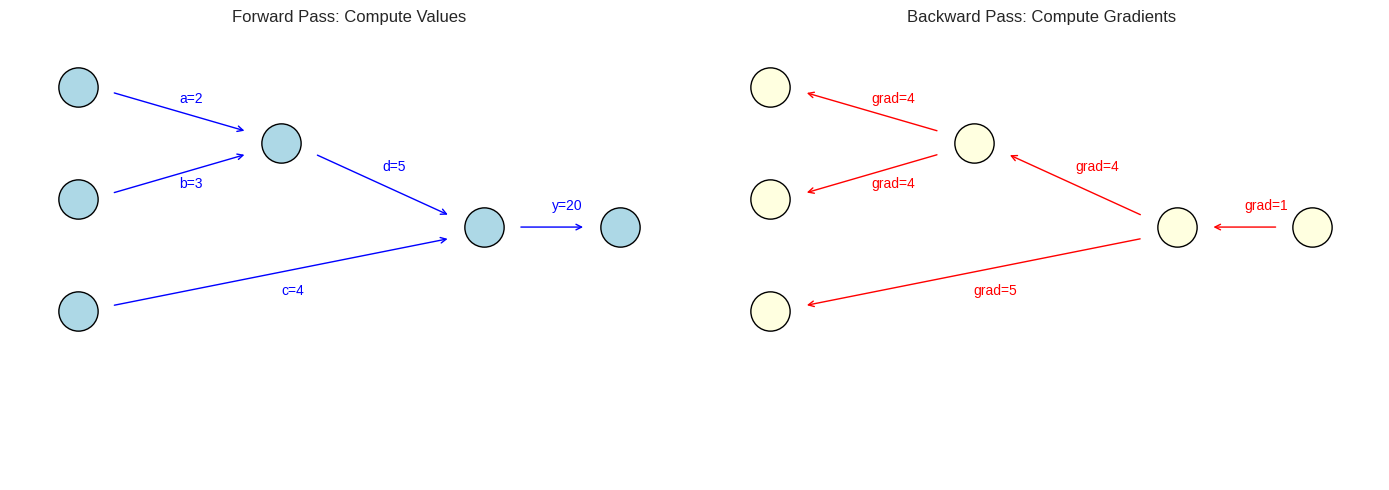

In [6]:
# Visualization of y = (a + b) * c
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Forward pass
ax = axes[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)

# Nodes
nodes = {'a': (1, 7), 'b': (1, 5), 'c': (1, 3),
         '+': (4, 6), '*': (7, 4.5), 'y': (9, 4.5)}
for name, (x, y) in nodes.items():
    ax.scatter([x], [y], s=800, c='lightblue', edgecolors='black', zorder=5)
    ax.text(x, y, name, ha='center', va='center', fontsize=12)

# Edges with values
ax.annotate('', xy=(3.5, 6.2), xytext=(1.5, 6.9),
            arrowprops=dict(arrowstyle='->', color='blue'))
ax.text(2.5, 6.7, 'a=2', fontsize=10, color='blue')

ax.annotate('', xy=(3.5, 5.8), xytext=(1.5, 5.1),
            arrowprops=dict(arrowstyle='->', color='blue'))
ax.text(2.5, 5.2, 'b=3', fontsize=10, color='blue')

ax.annotate('', xy=(6.5, 4.7), xytext=(4.5, 5.8),
            arrowprops=dict(arrowstyle='->', color='blue'))
ax.text(5.5, 5.5, 'd=5', fontsize=10, color='blue')

ax.annotate('', xy=(6.5, 4.3), xytext=(1.5, 3.1),
            arrowprops=dict(arrowstyle='->', color='blue'))
ax.text(4, 3.3, 'c=4', fontsize=10, color='blue')

ax.annotate('', xy=(8.5, 4.5), xytext=(7.5, 4.5),
            arrowprops=dict(arrowstyle='->', color='blue'))
ax.text(8, 4.8, 'y=20', fontsize=10, color='blue')

ax.set_title('Forward Pass: Compute Values', fontsize=12)
ax.axis('off')

# Backward pass
ax = axes[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)

for name, (x, y) in nodes.items():
    ax.scatter([x], [y], s=800, c='lightyellow', edgecolors='black', zorder=5)
    ax.text(x, y, name, ha='center', va='center', fontsize=12)

# Backward edges with gradients
ax.annotate('', xy=(1.5, 6.9), xytext=(3.5, 6.2),
            arrowprops=dict(arrowstyle='->', color='red'))
ax.text(2.5, 6.7, 'grad=4', fontsize=10, color='red')

ax.annotate('', xy=(1.5, 5.1), xytext=(3.5, 5.8),
            arrowprops=dict(arrowstyle='->', color='red'))
ax.text(2.5, 5.2, 'grad=4', fontsize=10, color='red')

ax.annotate('', xy=(4.5, 5.8), xytext=(6.5, 4.7),
            arrowprops=dict(arrowstyle='->', color='red'))
ax.text(5.5, 5.5, 'grad=4', fontsize=10, color='red')

ax.annotate('', xy=(1.5, 3.1), xytext=(6.5, 4.3),
            arrowprops=dict(arrowstyle='->', color='red'))
ax.text(4, 3.3, 'grad=5', fontsize=10, color='red')

ax.annotate('', xy=(7.5, 4.5), xytext=(8.5, 4.5),
            arrowprops=dict(arrowstyle='->', color='red'))
ax.text(8, 4.8, 'grad=1', fontsize=10, color='red')

ax.set_title('Backward Pass: Compute Gradients', fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.show()

---

# Part 3: Backpropagation in Neural Networks

---

## 3.1 A Simple Neural Network

Let's manually compute backprop for a 1-layer network:

- Input: $x$
- Weight: $w$, Bias: $b$
- Pre-activation: $z = wx + b$
- Output: $\hat{y} = \sigma(z)$ (sigmoid)
- Loss: $L = (y - \hat{y})^2$ (MSE)

In [7]:
# Manual backpropagation for a single neuron

# Values
x = 2.0
y_true = 1.0
w = 0.5
b = 0.1

# ============ FORWARD PASS ============
z = w * x + b           # Pre-activation
y_pred = sigmoid(z)     # Activation (prediction)
loss = (y_true - y_pred) ** 2  # MSE loss

print("=== FORWARD PASS ===")
print(f"x = {x}")
print(f"w = {w}, b = {b}")
print(f"z = w*x + b = {z}")
print(f"y_pred = sigmoid(z) = {y_pred:.4f}")
print(f"y_true = {y_true}")
print(f"loss = (y_true - y_pred)^2 = {loss:.4f}")

=== FORWARD PASS ===
x = 2.0
w = 0.5, b = 0.1
z = w*x + b = 1.1
y_pred = sigmoid(z) = 0.7503
y_true = 1.0
loss = (y_true - y_pred)^2 = 0.0624


In [8]:
# ============ BACKWARD PASS ============
# We want: dL/dw and dL/db

# Step 1: dL/d(y_pred)
# L = (y_true - y_pred)^2
# dL/d(y_pred) = -2(y_true - y_pred) = 2(y_pred - y_true)
dL_dy_pred = 2 * (y_pred - y_true)

# Step 2: d(y_pred)/dz
# y_pred = sigmoid(z)
# d(sigmoid)/dz = sigmoid(z) * (1 - sigmoid(z))
dy_pred_dz = y_pred * (1 - y_pred)

# Step 3: dz/dw and dz/db
# z = w*x + b
# dz/dw = x
# dz/db = 1
dz_dw = x
dz_db = 1

# Apply chain rule
dL_dz = dL_dy_pred * dy_pred_dz      # Chain: dL/dz = dL/dy_pred * dy_pred/dz
dL_dw = dL_dz * dz_dw                # Chain: dL/dw = dL/dz * dz/dw
dL_db = dL_dz * dz_db                # Chain: dL/db = dL/dz * dz/db

print("\n=== BACKWARD PASS ===")
print(f"dL/d(y_pred) = 2(y_pred - y_true) = {dL_dy_pred:.4f}")
print(f"d(y_pred)/dz = sigmoid(z)(1-sigmoid(z)) = {dy_pred_dz:.4f}")
print(f"dz/dw = x = {dz_dw}")
print(f"dz/db = 1")
print(f"\ndL/dz = dL/dy_pred * dy_pred/dz = {dL_dz:.4f}")
print(f"dL/dw = dL/dz * dz/dw = {dL_dw:.4f}")
print(f"dL/db = dL/dz * dz/db = {dL_db:.4f}")


=== BACKWARD PASS ===
dL/d(y_pred) = 2(y_pred - y_true) = -0.4995
d(y_pred)/dz = sigmoid(z)(1-sigmoid(z)) = 0.1874
dz/dw = x = 2.0
dz/db = 1

dL/dz = dL/dy_pred * dy_pred/dz = -0.0936
dL/dw = dL/dz * dz/dw = -0.1872
dL/db = dL/dz * dz/db = -0.0936


In [9]:
# Verify with PyTorch
x_t = torch.tensor(2.0)
y_true_t = torch.tensor(1.0)
w_t = torch.tensor(0.5, requires_grad=True)
b_t = torch.tensor(0.1, requires_grad=True)

z_t = w_t * x_t + b_t
y_pred_t = torch.sigmoid(z_t)
loss_t = (y_true_t - y_pred_t) ** 2

loss_t.backward()

print("\n=== PyTorch Verification ===")
print(f"Manual dL/dw = {dL_dw:.6f}")
print(f"PyTorch dL/dw = {w_t.grad.item():.6f}")
print(f"\nManual dL/db = {dL_db:.6f}")
print(f"PyTorch dL/db = {b_t.grad.item():.6f}")


=== PyTorch Verification ===
Manual dL/dw = -0.187175
PyTorch dL/dw = -0.187175

Manual dL/db = -0.093587
PyTorch dL/db = -0.093587


## 3.2 Two-Layer Network

Now let's do backprop for a 2-layer network:

- Layer 1: $h = \sigma(W_1 x + b_1)$
- Layer 2: $\hat{y} = \sigma(W_2 h + b_2)$
- Loss: $L = (y - \hat{y})^2$

In [10]:
# Two-layer network backpropagation
np.random.seed(42)

# Single sample
x = np.array([1.0, 2.0])  # 2 inputs
y_true = np.array([1.0])   # 1 output

# Layer 1: 2 inputs -> 3 hidden
W1 = np.random.randn(3, 2) * 0.5
b1 = np.zeros(3)

# Layer 2: 3 hidden -> 1 output
W2 = np.random.randn(1, 3) * 0.5
b2 = np.zeros(1)

print("Network architecture: 2 -> 3 -> 1")
print(f"W1 shape: {W1.shape}")
print(f"W2 shape: {W2.shape}")

Network architecture: 2 -> 3 -> 1
W1 shape: (3, 2)
W2 shape: (1, 3)


In [11]:
# Forward pass
z1 = W1 @ x + b1           # (3,)
h = sigmoid(z1)            # (3,)
z2 = W2 @ h + b2           # (1,)
y_pred = sigmoid(z2)       # (1,)
loss = np.mean((y_true - y_pred) ** 2)

print("=== FORWARD PASS ===")
print(f"x shape: {x.shape}")
print(f"z1 = W1 @ x + b1: {z1}")
print(f"h = sigmoid(z1): {h}")
print(f"z2 = W2 @ h + b2: {z2}")
print(f"y_pred = sigmoid(z2): {y_pred}")
print(f"loss: {loss:.4f}")

=== FORWARD PASS ===
x shape: (2,)
z1 = W1 @ x + b1: [ 0.11009278  1.84687413 -0.35121364]
h = sigmoid(z1): [0.52749543 0.86375967 0.41308815]
z2 = W2 @ h + b2: [0.6509862]
y_pred = sigmoid(z2): [0.65723267]
loss: 0.1175


In [12]:
# Backward pass

# Output layer gradients
dL_dy_pred = 2 * (y_pred - y_true)           # (1,)
dy_pred_dz2 = y_pred * (1 - y_pred)          # (1,)
dL_dz2 = dL_dy_pred * dy_pred_dz2            # (1,)

dL_dW2 = dL_dz2.reshape(-1, 1) @ h.reshape(1, -1)  # (1, 3)
dL_db2 = dL_dz2                              # (1,)

# Hidden layer gradients
dL_dh = W2.T @ dL_dz2                        # (3,)
dh_dz1 = h * (1 - h)                         # (3,)
dL_dz1 = dL_dh * dh_dz1                      # (3,)

dL_dW1 = dL_dz1.reshape(-1, 1) @ x.reshape(1, -1)  # (3, 2)
dL_db1 = dL_dz1                              # (3,)

print("=== BACKWARD PASS ===")
print(f"dL/dW2 shape: {dL_dW2.shape}")
print(f"dL/db2 shape: {dL_db2.shape}")
print(f"dL/dW1 shape: {dL_dW1.shape}")
print(f"dL/db1 shape: {dL_db1.shape}")

=== BACKWARD PASS ===
dL/dW2 shape: (1, 3)
dL/db2 shape: (1,)
dL/dW1 shape: (3, 2)
dL/db1 shape: (3,)


In [13]:
# Verify with PyTorch
x_t = torch.tensor(x, dtype=torch.float32)
y_true_t = torch.tensor(y_true, dtype=torch.float32)
W1_t = torch.tensor(W1, dtype=torch.float32, requires_grad=True)
b1_t = torch.tensor(b1, dtype=torch.float32, requires_grad=True)
W2_t = torch.tensor(W2, dtype=torch.float32, requires_grad=True)
b2_t = torch.tensor(b2, dtype=torch.float32, requires_grad=True)

# Forward
z1_t = W1_t @ x_t + b1_t
h_t = torch.sigmoid(z1_t)
z2_t = W2_t @ h_t + b2_t
y_pred_t = torch.sigmoid(z2_t)
loss_t = torch.mean((y_true_t - y_pred_t) ** 2)

loss_t.backward()

print("=== Verification ===")
print(f"dL/dW2 match: {np.allclose(dL_dW2, W2_t.grad.numpy())}")
print(f"dL/db2 match: {np.allclose(dL_db2, b2_t.grad.numpy())}")
print(f"dL/dW1 match: {np.allclose(dL_dW1, W1_t.grad.numpy())}")
print(f"dL/db1 match: {np.allclose(dL_db1, b1_t.grad.numpy())}")

=== Verification ===
dL/dW2 match: True
dL/db2 match: True
dL/dW1 match: True
dL/db1 match: True


---

# Part 4: The General Backpropagation Algorithm

---

## 4.1 Algorithm Overview

```
1. FORWARD PASS:
   - Compute and cache all intermediate values (z, h, etc.)

2. BACKWARD PASS:
   - Start with dL/d(output) = gradient of loss
   - For each layer (from output to input):
       - Compute gradient w.r.t. pre-activation (dL/dz)
       - Compute gradient w.r.t. weights (dL/dW)
       - Compute gradient w.r.t. bias (dL/db)
       - Pass gradient to previous layer

3. UPDATE:
   - Update all parameters using gradients
```

## 4.2 Key Insight: Local Gradients

Each operation only needs to know:
1. Its **local gradient** (how output changes w.r.t. inputs)
2. The **upstream gradient** (gradient from the layer above)

The full gradient is just: **upstream gradient x local gradient**

In [14]:
# Example: Different operations and their local gradients

class Add:
    """z = x + y"""
    def forward(self, x, y):
        return x + y

    def backward(self, dL_dz):
        # dz/dx = 1, dz/dy = 1
        return dL_dz * 1, dL_dz * 1

class Multiply:
    """z = x * y"""
    def forward(self, x, y):
        self.x, self.y = x, y
        return x * y

    def backward(self, dL_dz):
        # dz/dx = y, dz/dy = x
        return dL_dz * self.y, dL_dz * self.x

class Sigmoid:
    """y = 1 / (1 + exp(-x))"""
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dL_dy):
        # dy/dx = y * (1 - y)
        return dL_dy * self.out * (1 - self.out)

class ReLU:
    """y = max(0, x)"""
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dL_dy):
        # dy/dx = 1 if x > 0, else 0
        return dL_dy * (self.x > 0)

# Test
mul = Multiply()
sig = Sigmoid()

x, w = 2.0, 3.0
z = mul.forward(x, w)
y = sig.forward(z)

print(f"x={x}, w={w}")
print(f"z = x * w = {z}")
print(f"y = sigmoid(z) = {y:.4f}")

# Backward
dL_dy = 1.0  # Assume this comes from loss
dL_dz = sig.backward(dL_dy)
dL_dx, dL_dw = mul.backward(dL_dz)

print(f"\ndL/dy = {dL_dy}")
print(f"dL/dz = {dL_dz:.4f}")
print(f"dL/dx = {dL_dx:.4f}")
print(f"dL/dw = {dL_dw:.4f}")

x=2.0, w=3.0
z = x * w = 6.0
y = sigmoid(z) = 0.9975

dL/dy = 1.0
dL/dz = 0.0025
dL/dx = 0.0074
dL/dw = 0.0049


---

# Part 5: PyTorch Autograd

---

## 5.1 How PyTorch Tracks Gradients

When `requires_grad=True`:
1. PyTorch builds a computational graph
2. Each tensor remembers how it was created (`grad_fn`)
3. Calling `.backward()` traverses this graph backwards

In [15]:
# Examine the computation graph
x = torch.tensor([2.0], requires_grad=True)
w = torch.tensor([3.0], requires_grad=True)

y = x * w
z = y ** 2
loss = z.sum()

print(f"x.grad_fn: {x.grad_fn}")  # None - it's a leaf
print(f"y.grad_fn: {y.grad_fn}")  # MulBackward
print(f"z.grad_fn: {z.grad_fn}")  # PowBackward
print(f"loss.grad_fn: {loss.grad_fn}")  # SumBackward

x.grad_fn: None
y.grad_fn: <MulBackward0 object at 0x78e2465fb6d0>
z.grad_fn: <PowBackward0 object at 0x78e246179cc0>
loss.grad_fn: <SumBackward0 object at 0x78e246179cc0>


In [16]:
# Backward and check gradients
loss.backward()

# loss = (x*w)^2 = x^2 * w^2
# dL/dx = 2*x*w^2
# dL/dw = 2*w*x^2

print(f"x.grad = {x.grad.item()}")  # 2 * 2 * 9 = 36
print(f"w.grad = {w.grad.item()}")  # 2 * 3 * 4 = 24

print(f"\nVerification:")
print(f"2*x*w^2 = 2*2*9 = {2*2*9}")
print(f"2*w*x^2 = 2*3*4 = {2*3*4}")

x.grad = 36.0
w.grad = 24.0

Verification:
2*x*w^2 = 2*2*9 = 36
2*w*x^2 = 2*3*4 = 24


## 5.2 .backward() with retain_graph

In [17]:
# By default, the graph is freed after backward()
x = torch.tensor([1.0], requires_grad=True)
y = x ** 2
y.backward()
print(f"First backward: x.grad = {x.grad.item()}")

# Second backward would fail without retain_graph=True
x.grad.zero_()
y = x ** 2
y.backward(retain_graph=True)
print(f"With retain_graph: x.grad = {x.grad.item()}")

First backward: x.grad = 2.0
With retain_graph: x.grad = 2.0


---

# Key Points Summary

---

## Chain Rule
- Backprop is just the chain rule applied systematically
- $\frac{dL}{dw} = \frac{dL}{dy} \cdot \frac{dy}{dz} \cdot \frac{dz}{dw}$

## Computational Graphs
- Forward pass: compute and cache values
- Backward pass: compute gradients using cached values

## Local Gradients
- Each operation computes its local gradient
- Full gradient = upstream gradient x local gradient

## PyTorch Autograd
- Automatically builds computation graph
- `.backward()` traverses graph to compute gradients
- Use `.grad.zero_()` before each new backward pass

---

# Interview Tips

---

## Common Questions

**Q: What is backpropagation?**
A: An algorithm for efficiently computing gradients in neural networks by applying the chain rule backwards through the computation graph. It computes how much each weight contributed to the loss.

**Q: Why do we need to store intermediate values during forward pass?**
A: To compute gradients during backward pass. For example, the gradient of sigmoid depends on its output value, which we computed during forward pass.

**Q: What is the relationship between backprop and the chain rule?**
A: Backpropagation IS the chain rule applied systematically from output to input. Each layer multiplies the incoming gradient by its local gradient and passes it to the previous layer.

---

# Practice Exercises

---

## Exercise 1: Manual Backprop

For $y = \text{ReLU}(wx + b)$ with MSE loss, compute $\frac{dL}{dw}$ and $\frac{dL}{db}$ when $x=1, w=2, b=-1, y_{true}=3$.

In [18]:
# Your calculation here
# z = wx + b = 2*1 + (-1) = 1
# y_pred = ReLU(1) = 1
# L = (3 - 1)^2 = 4

# Backward:
# dL/dy_pred = ?
# dy_pred/dz = ?
# dL/dw = ?
# dL/db = ?

## Solutions

In [19]:
# Exercise 1 Solution
print("=== Forward ===")
x, w, b, y_true = 1.0, 2.0, -1.0, 3.0
z = w * x + b  # = 1
y_pred = max(0, z)  # ReLU(1) = 1
L = (y_true - y_pred) ** 2  # = 4
print(f"z = {z}, y_pred = {y_pred}, L = {L}")

print("\n=== Backward ===")
dL_dy_pred = 2 * (y_pred - y_true)  # = -4
dy_pred_dz = 1 if z > 0 else 0  # = 1 (z=1>0)
dL_dz = dL_dy_pred * dy_pred_dz  # = -4
dL_dw = dL_dz * x  # = -4
dL_db = dL_dz * 1  # = -4
print(f"dL/dw = {dL_dw}, dL/db = {dL_db}")

# Verify
w_t = torch.tensor(2.0, requires_grad=True)
b_t = torch.tensor(-1.0, requires_grad=True)
z_t = w_t * 1.0 + b_t
y_t = torch.relu(z_t)
L_t = (3.0 - y_t) ** 2
L_t.backward()
print(f"\nPyTorch: dL/dw = {w_t.grad.item()}, dL/db = {b_t.grad.item()}")

=== Forward ===
z = 1.0, y_pred = 1.0, L = 4.0

=== Backward ===
dL/dw = -4.0, dL/db = -4.0

PyTorch: dL/dw = -4.0, dL/db = -4.0


---

## Next Module: [10 - Optimizers](../10_optimizers/10_optimizers.ipynb)

Now that we understand how gradients are computed, let's learn about advanced optimizers that use these gradients more effectively.